In [800]:
# Import all dependencies
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import urllib
import tarfile
import numpy as np
from pandas import pivot_table
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
warnings.filterwarnings('ignore')


In [2]:
# Load the history dataset - has indo of all stations
data_path_isd_stations = '/Users/prashantshivajibhapkar/Documents/isd/isd-history.csv'
isd_stations_df = pd.read_csv(data_path_isd_stations)
isd_stations_df['USAF'] = isd_stations_df['USAF'].astype('str')
isd_stations_df['WBAN'] = isd_stations_df['WBAN'].astype('str')

In [3]:
isd_stations_df.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,20140923,20150926
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,20050101,20120731
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,20100519,20120323


Drilling down on California stations

In [784]:
isd_stations_df[(isd_stations_df['CTRY']=='US') & 
                (isd_stations_df['STATE']=='CA') & 
                (isd_stations_df['STATION NAME'].str.contains('LOS')) &
                (isd_stations_df['END']//10000 ==2021)
               ]

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
18768,722950,23174,LOS ANGELES INTERNATIONAL AIRPORT,US,CA,KLAX,33.938,-118.389,29.6,19440101,20210926
18785,722975,53141,LOS ALAMITOS AAF AIRPORT,US,CA,KSLI,33.790,-118.052,10.7,20060101,20210926
19708,724938,93231,SAN CARLOS AIRPORT,US,CA,KSQL,37.517,-122.250,1.5,20060101,20210926
27232,994035,99999,LOS ANGELES,US,CA,NaN,33.720,-118.272,2.0,20080101,20210925


In [502]:
isd_stations_df[(isd_stations_df['USAF']=='028360')].sort_values('BEGIN')

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
1076,028360,99999,SODANKYLA,FI,NaN,EFSO,67.395,26.619,183.5,19170101,20210925


This data is really interesting in terms of what you can do with the it. One idea could be to focus on the latest data for all the stations and see if there are any patters in that data like if there are certain clusters of locations that are relatively hotter than the rest for instance.  
I thought that it would be really interesting to see the time series aspect rather than cross-sectional one (snapshot). Given the ongoing discussions on climate change and recent forest fires that took place in California, it would be intersting to see if the climate has really changed over time and if there are indications of it getting worse/better over time  - **Global Warming/Climate Change**

Let's first grab data for - `LOS ANGELES INTERNATIONAL AIRPORT (USAF 722950)` as this location is not that far from fire events that have happenned in the past and new ones too. Also, there is data available for a larger time span - 1944-2021

In [545]:
def get_isd_lite_data(usaf, wban, http_path, local_path, begin, end):
    """
    Fetches data over HTTP (http_path) and saves at local_path
    in: usaf (USAF of station), wban (WBAN of station), http_path (http path where data is located),
        local_path (local path where data will be downloaded and saved), begin (beginning year), end (ending year)
    """
    succ_cnt=0 # counter to count the number of successfull http requests
    fail_cnt=0 # counter to count the number of successfull http requests
    not_found=[] # array/list to track the years for which there was no data available
    found=[] # array/list to track the years for which there was data available
    for year in range(begin, end):
        try:
            urllib.request.urlretrieve(http_path + '/{}/{}-{}-{}.gz'.format(year, usaf, wban, year), 
                           local_path + '/{}-{}-{}.gz'.format(usaf, wban, year))
            succ_cnt+=1
            found.append(year)
        except urllib.error.URLError as e: # catch http error
            fail_cnt+=1
            not_found.append(year)
            
    # Print fetch summary
    print("Summary")
    print("Data Found For {} Years: {}".format(succ_cnt, found))
    print("Data Not Found For {} Years: {}".format(fail_cnt, not_found))

In [570]:
# Get data for LOS ANGELES INTERNATIONAL AIRPORT (USAF 722950)
usaf = '722950'
wban = isd_stations_df[(isd_stations_df['USAF']==usaf)]['WBAN'].values[0]
http_path='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite'

# Set up the local location to fecth the data into
cwd = os.getcwd()
la_ca_path = cwd + '/la_ca_isd'
if not os.path.exists(la_ca_path):
    os.mkdir(la_ca_path)

# Get range of dates for which the data is expected to be present
begin = isd_stations_df[(isd_stations_df['USAF']==usaf)]['BEGIN'].values[0] // 10000
end = isd_stations_df[(isd_stations_df['USAF']==usaf)]['END'].values[0] // 10000
    
# Fetch the data
get_isd_lite_data(usaf=usaf, wban=wban, http_path=http_path, local_path=la_ca_path, begin=begin, end=end)

Summary
Data Found For 49 Years: [1944, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Data Not Found For 28 Years: [1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972]


In [571]:
# Load Fetched data in a dataframe

# List all files in the data folder
data_files_isd = [f for f in listdir(la_ca_path) if isfile(join(la_ca_path, f)) and len(f)==17]

col_names = ['year', 'month', 'day', 'hour', 'air_temp', 'dew_pt_temp', 
        'sea_lvl_pressure', 'wind_direction', 'wind_speed_rate', 'sky_cond_cov_code', 
        'liquid_prec_one_hour', 'liquid_prec_six_hours', 'usaf', 'wban']
isd_lite_df = pd.DataFrame(columns=col_names)

for f in data_files_isd:
    tmp_df = pd.read_csv(la_ca_path+'/'+f, delim_whitespace=True, names=col_names, encoding="utf-8")
    tmp_df['usaf'] = f.split('-')[0]
    tmp_df['wban'] = f.split('-')[1]
    isd_lite_df = pd.concat([isd_lite_df,tmp_df], axis=0)
    

In [572]:
isd_lite_df.sort_values('year').head()

,year,month,day,hour,air_temp,dew_pt_temp,sea_lvl_pressure,wind_direction,wind_speed_rate,sky_cond_cov_code,liquid_prec_one_hour,liquid_prec_six_hours,usaf,wban
6804,1944,10,31,8,-9999,-9999,-9999,293,-9999,-9999,-9999,-9999,722950,23174
2261,1944,4,5,0,163,107,10163,248,51,-9999,-9999,-9999,722950,23174
2262,1944,4,5,1,157,113,10163,248,51,-9999,-9999,-9999,722950,23174
2263,1944,4,5,2,146,113,10163,68,15,-9999,-9999,-9999,722950,23174
2264,1944,4,5,3,146,102,10169,338,26,-9999,-9999,-9999,722950,23174


In [573]:
isd_lite_df.tail()

,year,month,day,hour,air_temp,dew_pt_temp,sea_lvl_pressure,wind_direction,wind_speed_rate,sky_cond_cov_code,liquid_prec_one_hour,liquid_prec_six_hours,usaf,wban
8755,1985,12,31,19,161,106,10222,-9999,0,8,0,-9999,722950,23174
8756,1985,12,31,20,161,128,10207,240,41,8,0,-9999,722950,23174
8757,1985,12,31,21,161,128,10199,310,36,8,0,-9999,722950,23174
8758,1985,12,31,22,167,128,10196,230,36,8,0,-9999,722950,23174
8759,1985,12,31,23,156,128,10195,250,36,8,0,-9999,722950,23174


In [574]:
# Enforce dtype
for c in col_names:
    if c not in ['usaf', 'wban']:
        isd_lite_df[c] = isd_lite_df[c].astype('int')
    else:
        isd_lite_df[c] = isd_lite_df[c].astype('str')


In [575]:
# De-scale the values as per technical doc
isd_lite_df['air_temp'] = isd_lite_df.apply(lambda x: x['air_temp']/10 if x['air_temp']!=-9999 else x['air_temp'], axis=1)
isd_lite_df['dew_pt_temp'] = isd_lite_df.apply(lambda x: x['dew_pt_temp']/10 if x['dew_pt_temp']!=-9999 else x['dew_pt_temp'], axis=1)
isd_lite_df['wind_speed_rate'] = isd_lite_df.apply(lambda x: x['wind_speed_rate']/10 if x['wind_speed_rate']!=-9999 else x['wind_speed_rate'], axis=1)

In [576]:
isd_lite_df.describe()

,year,month,day,hour,air_temp,dew_pt_temp,sea_lvl_pressure,wind_direction,wind_speed_rate,sky_cond_cov_code,liquid_prec_one_hour,liquid_prec_six_hours
count,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000,427551.000000
mean,1995.665048,6.501809,15.724321,11.499784,16.331918,6.226939,10090.365255,-410.266834,-7.507562,-803.671852,-230.391071,-9081.880681
std,15.232872,3.441971,8.800788,6.922208,83.995578,217.603189,1114.368431,2402.863954,328.981381,2724.803895,1501.346463,2887.220568
min,1944.000000,1.000000,1.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
25%,1984.000000,4.000000,8.000000,5.000000,14.400000,8.900000,10127.000000,90.000000,2.100000,0.000000,0.000000,-9999.000000
50%,1996.000000,7.000000,16.000000,11.000000,17.200000,12.200000,10149.000000,240.000000,3.100000,2.000000,0.000000,-9999.000000
75%,2008.000000,9.000000,23.000000,17.000000,19.400000,15.000000,10176.000000,260.000000,4.600000,7.000000,0.000000,-9999.000000
max,2020.000000,12.000000,31.000000,23.000000,40.000000,22.800000,10346.000000,360.000000,25.800000,10.000000,378.000000,3000.000000


## Air Temperature

For this analyis, we are interested in the `air_temperature`

In [785]:
air_temp_df = isd_lite_df[((isd_lite_df['air_temp']!=-9999) | (isd_lite_df['air_temp']!=-9999.0)) & (isd_lite_df['year']!=1944)]

# Extract timestamp into a single column
air_temp_df['ts'] = air_temp_df.apply(lambda x: pd.Timestamp(x['year'], x['month'], x['day'], x['hour']), axis=1)

# Sort the data by timestamps
air_temp_df = air_temp_df.sort_values('ts')

In [578]:
air_temp_df.head()

,year,month,day,hour,air_temp,dew_pt_temp,sea_lvl_pressure,wind_direction,wind_speed_rate,sky_cond_cov_code,liquid_prec_one_hour,liquid_prec_six_hours,usaf,wban,ts
0,1973,1,1,0,18.3,-8.3,10147,40,6.7,0,0,0,722950,23174,1973-01-01 00:00:00
1,1973,1,1,1,16.7,-10.0,10151,20,6.7,0,0,0,722950,23174,1973-01-01 01:00:00
2,1973,1,1,2,15.6,-9.4,10163,30,4.6,0,0,0,722950,23174,1973-01-01 02:00:00
3,1973,1,1,3,15.0,-8.9,10171,20,3.1,0,0,0,722950,23174,1973-01-01 03:00:00
4,1973,1,1,4,14.4,-9.4,10176,20,3.1,0,0,0,722950,23174,1973-01-01 04:00:00


In [579]:
# Creating a dataframe from the above one selecting just the air_temp and indexing it on the timestamp field
air_temp_idx_df = air_temp_df[['ts', 'air_temp']].set_index('ts')
air_temp_idx_df.head()

,air_temp
ts,
1973-01-01 00:00:00,18.3
1973-01-01 01:00:00,16.7
1973-01-01 02:00:00,15.6
1973-01-01 03:00:00,15.0
1973-01-01 04:00:00,14.4


In [618]:
air_temp_idx_df.describe()

,air_temp
count,420718.000000
mean,17.047896
std,4.054475
min,1.100000
25%,14.400000
50%,17.200000
75%,19.400000
max,40.000000


<AxesSubplot:xlabel='ts'>

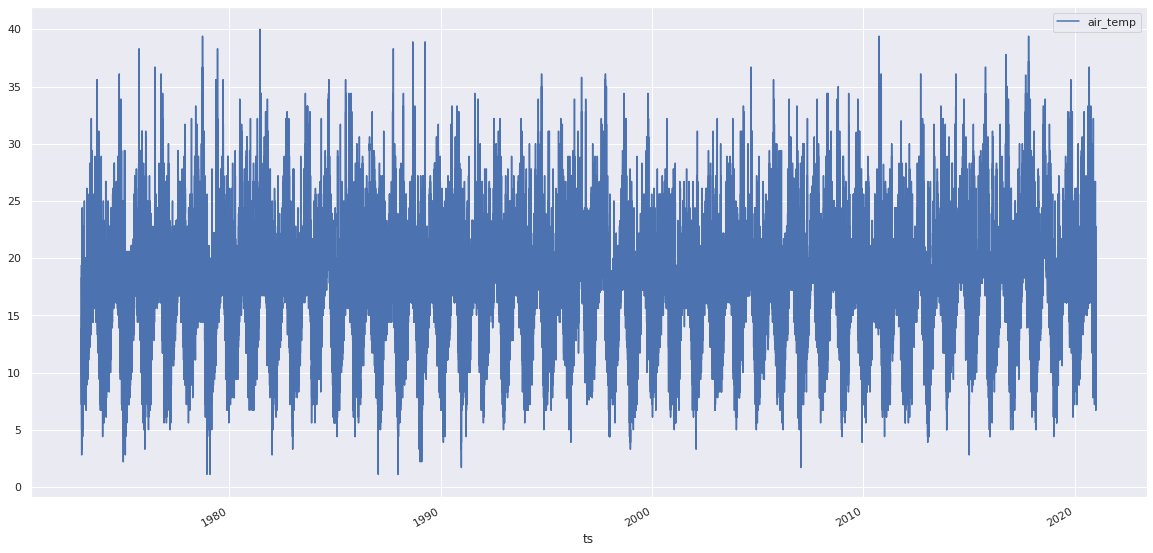

In [580]:
air_temp_idx_df.plot(figsize=(20,10))

The data looks pretty much stationary except a minute spike towards the end

In [581]:
#Check if there is data available for all hours for all years
tmp_days_per_month = air_temp_df.groupby(['year','month']).count()['hour']/24
tmp_days_per_month.head()

year  month
1973  1        31.0
      2        28.0
      3        31.0
      4        30.0
      5        31.0
Name: hour, dtype: float64

In [583]:
len(tmp_days_per_month[tmp_days_per_month<27])

0

Data is there for at least 27 days for all months from 1974 to 2020. some hourly observations are missing but that should be fine and those can be imputed with previous hour values if and when needed

Let's see if, over the years, monthly temperatiures have gone up

In [584]:
monthly_mean_temp_df = pd.DataFrame(air_temp_df.groupby(['year','month']).mean()['air_temp']).reset_index()
monthly_mean_temp_df.head()

,year,month,air_temp
0,1973,1,12.396505
1,1973,2,14.473363
2,1973,3,13.170699
3,1973,4,15.154167
4,1973,5,16.159274


In [585]:
# Pivoting to get a tabular view
monthly_mean_temp_pivot_df = pivot_table(data=monthly_mean_temp_df, index='year', columns='month', values='air_temp')
monthly_mean_temp_pivot_df.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1973,12.396505,14.473363,13.170699,15.154167,16.159274,18.609306,19.280645,19.931586,19.065000,17.608602,14.830972,14.043683
1974,12.012097,13.734226,13.476210,15.031111,16.391667,18.778056,20.820161,20.172446,19.677222,18.073387,16.155694,13.055108
1975,13.284140,12.660268,13.035753,13.306944,15.462366,17.125000,19.875538,19.384005,20.187639,17.854839,15.155556,13.161828
1976,14.326075,13.703879,14.120699,14.121389,16.751882,19.610139,20.553629,20.242339,20.840000,20.102957,18.233611,15.039516
1977,13.734274,14.925744,13.178091,15.300972,15.641801,17.653889,19.704704,21.022312,19.809583,18.364785,17.600278,15.652957


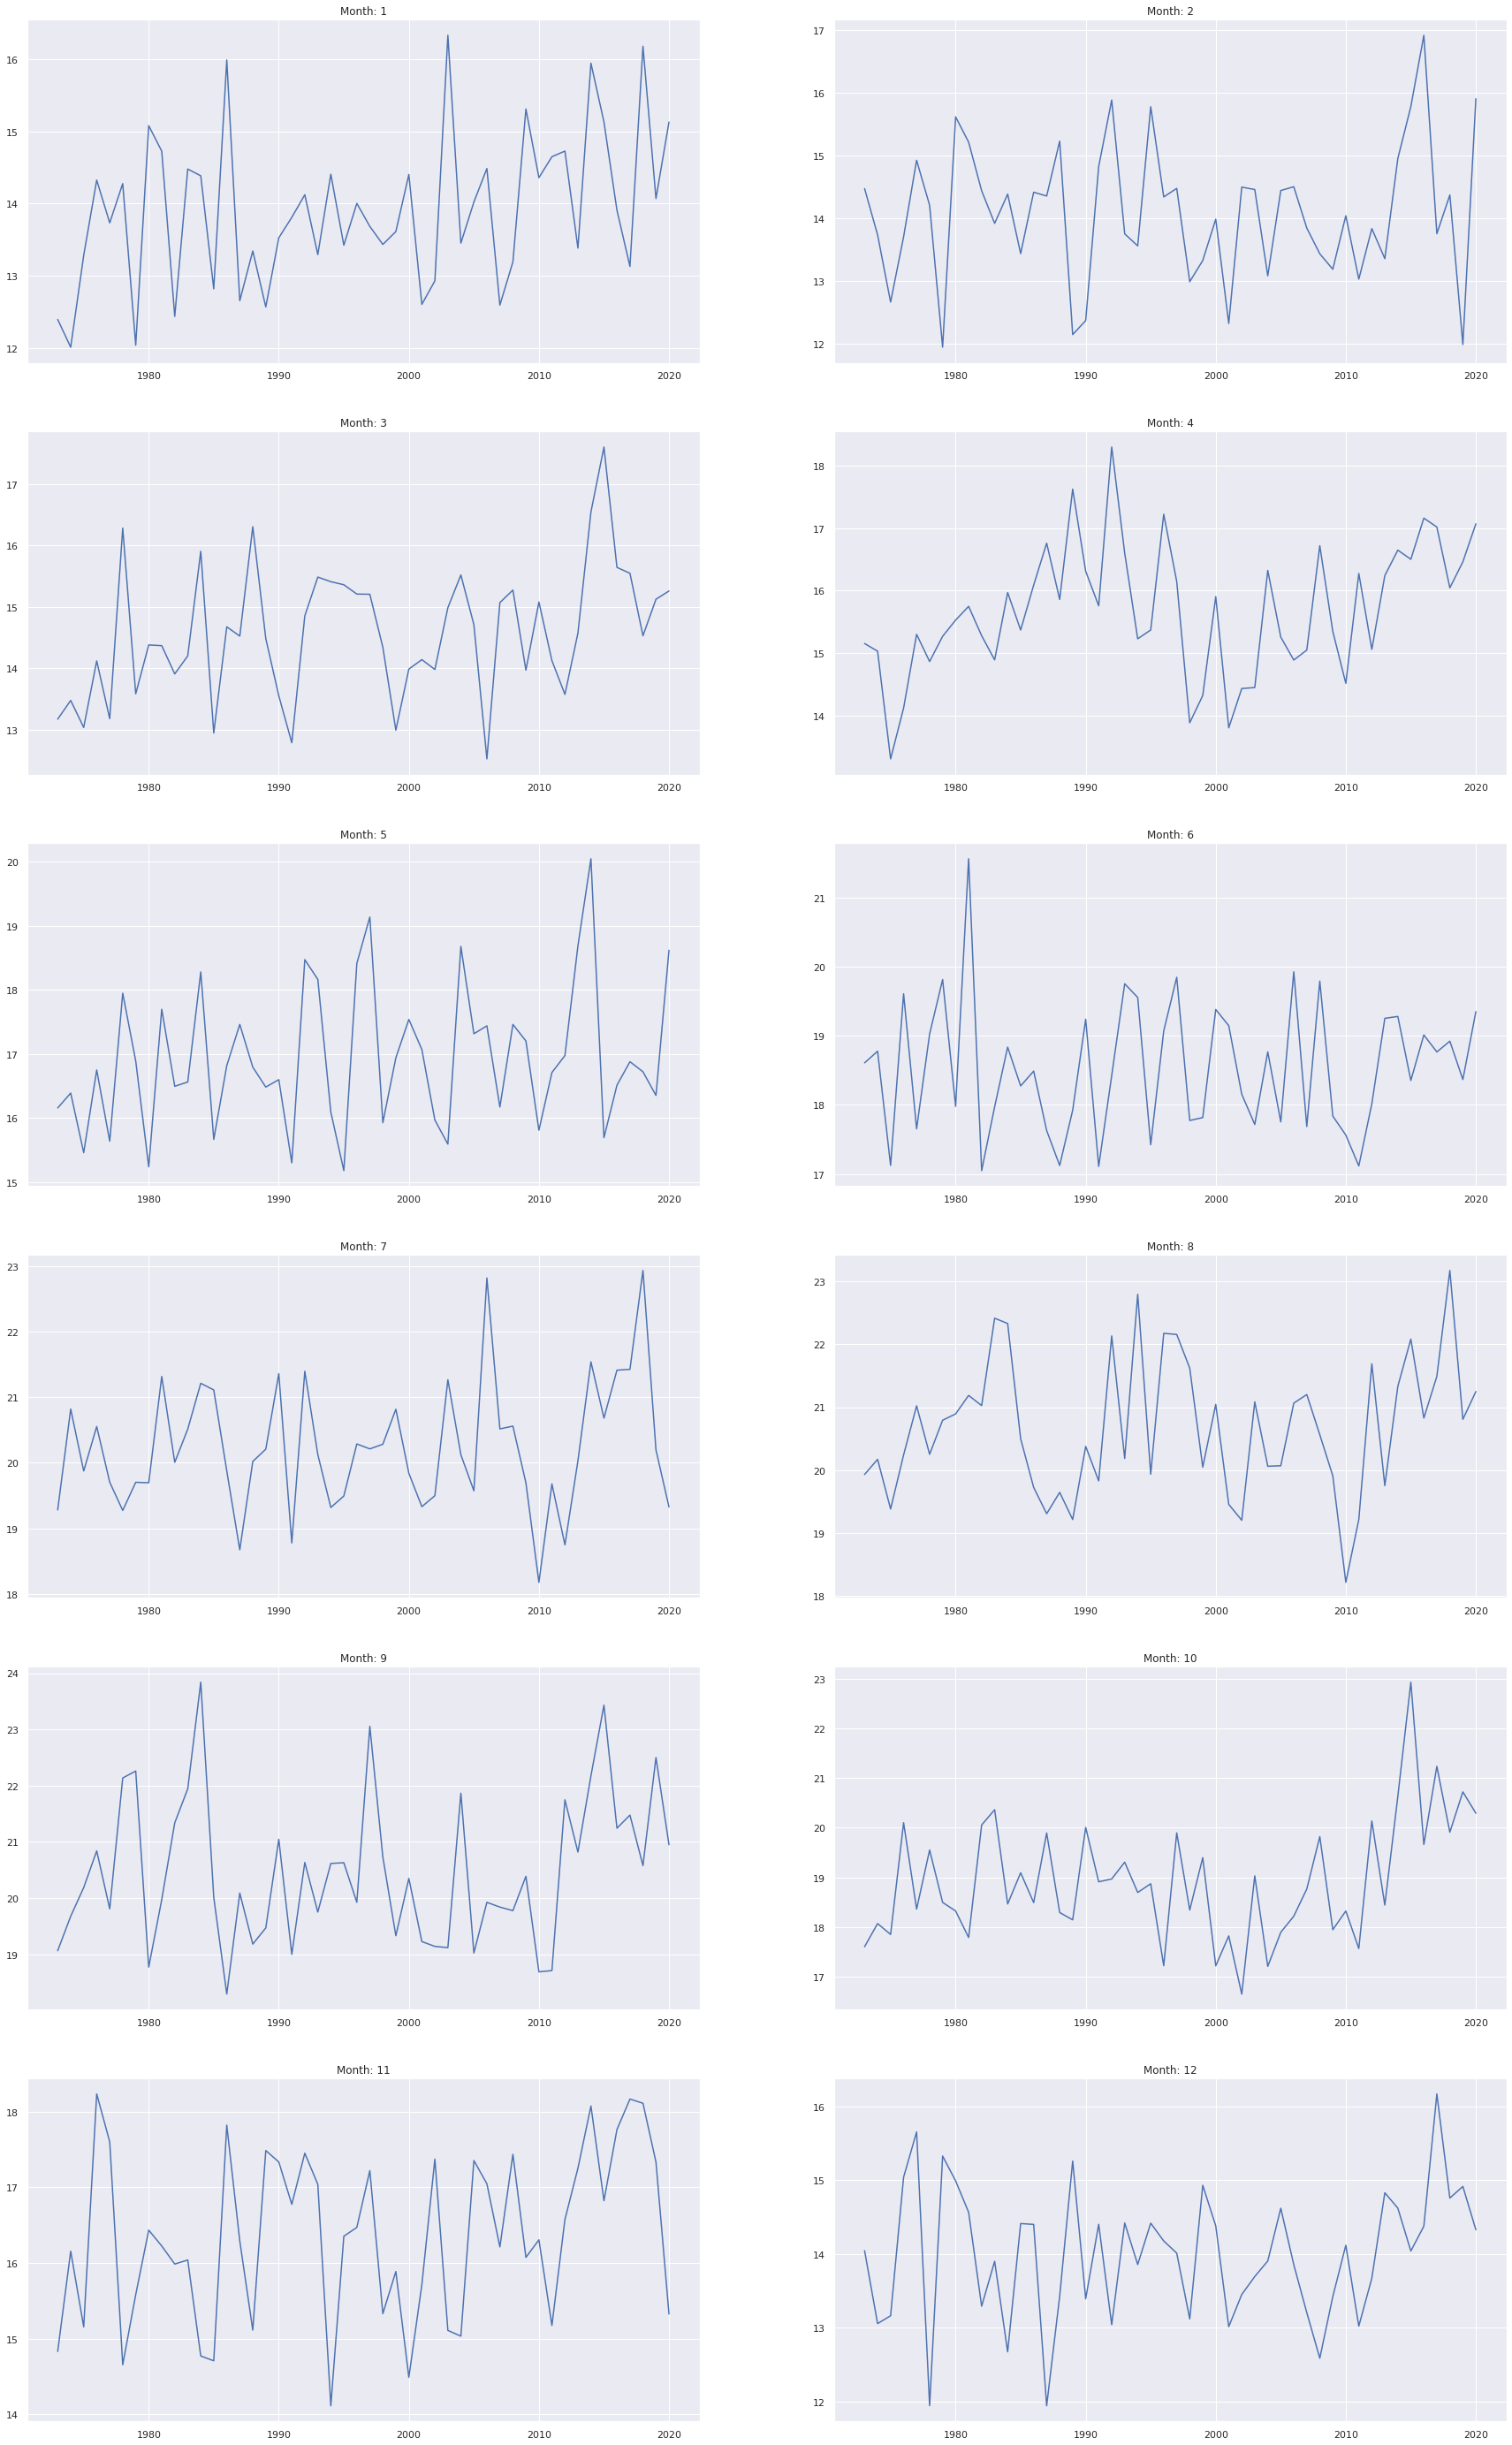

In [789]:
fig, axs = plt.subplots(6, 2, figsize=(30,50))
month = 1
for i in range(6):
    for j in range(2):
        axs[i, j].plot(monthly_mean_temp_pivot_df[month])
        axs[i, j].set_title("Month: {}".format(month))
        month+=1



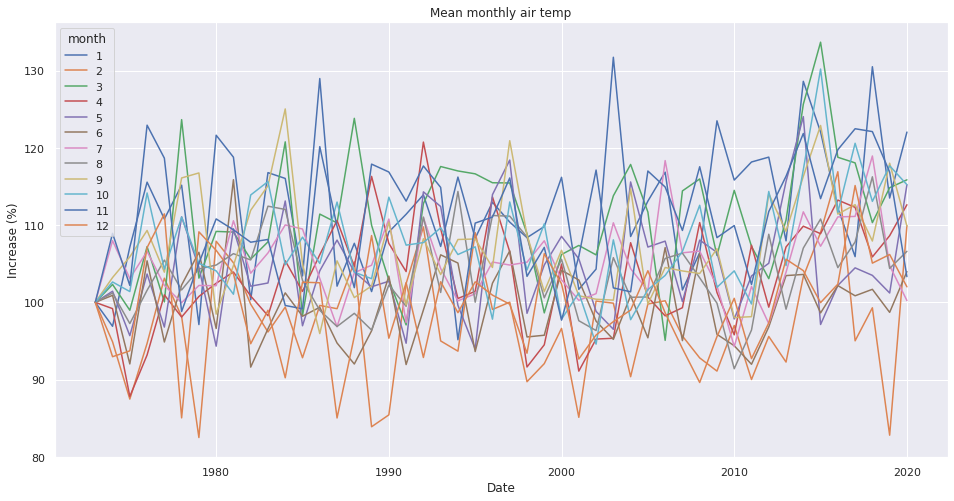

In [587]:
# Normalizing for all months (and getting % changes)
monthly_mean_temp_pivot_normalized_df = monthly_mean_temp_pivot_df.div(monthly_mean_temp_pivot_df.iloc[0]).mul(100)
monthly_mean_temp_pivot_normalized_df.plot(figsize=(16, 8), title="Mean monthly air temp")
plt.xlabel("Date")
plt.ylabel("Increase (%)");

Again the data looks mostly stationary with some dense spikes towards the end meaning more months were hotter sa there is more density in the upper portion of the plot at the end

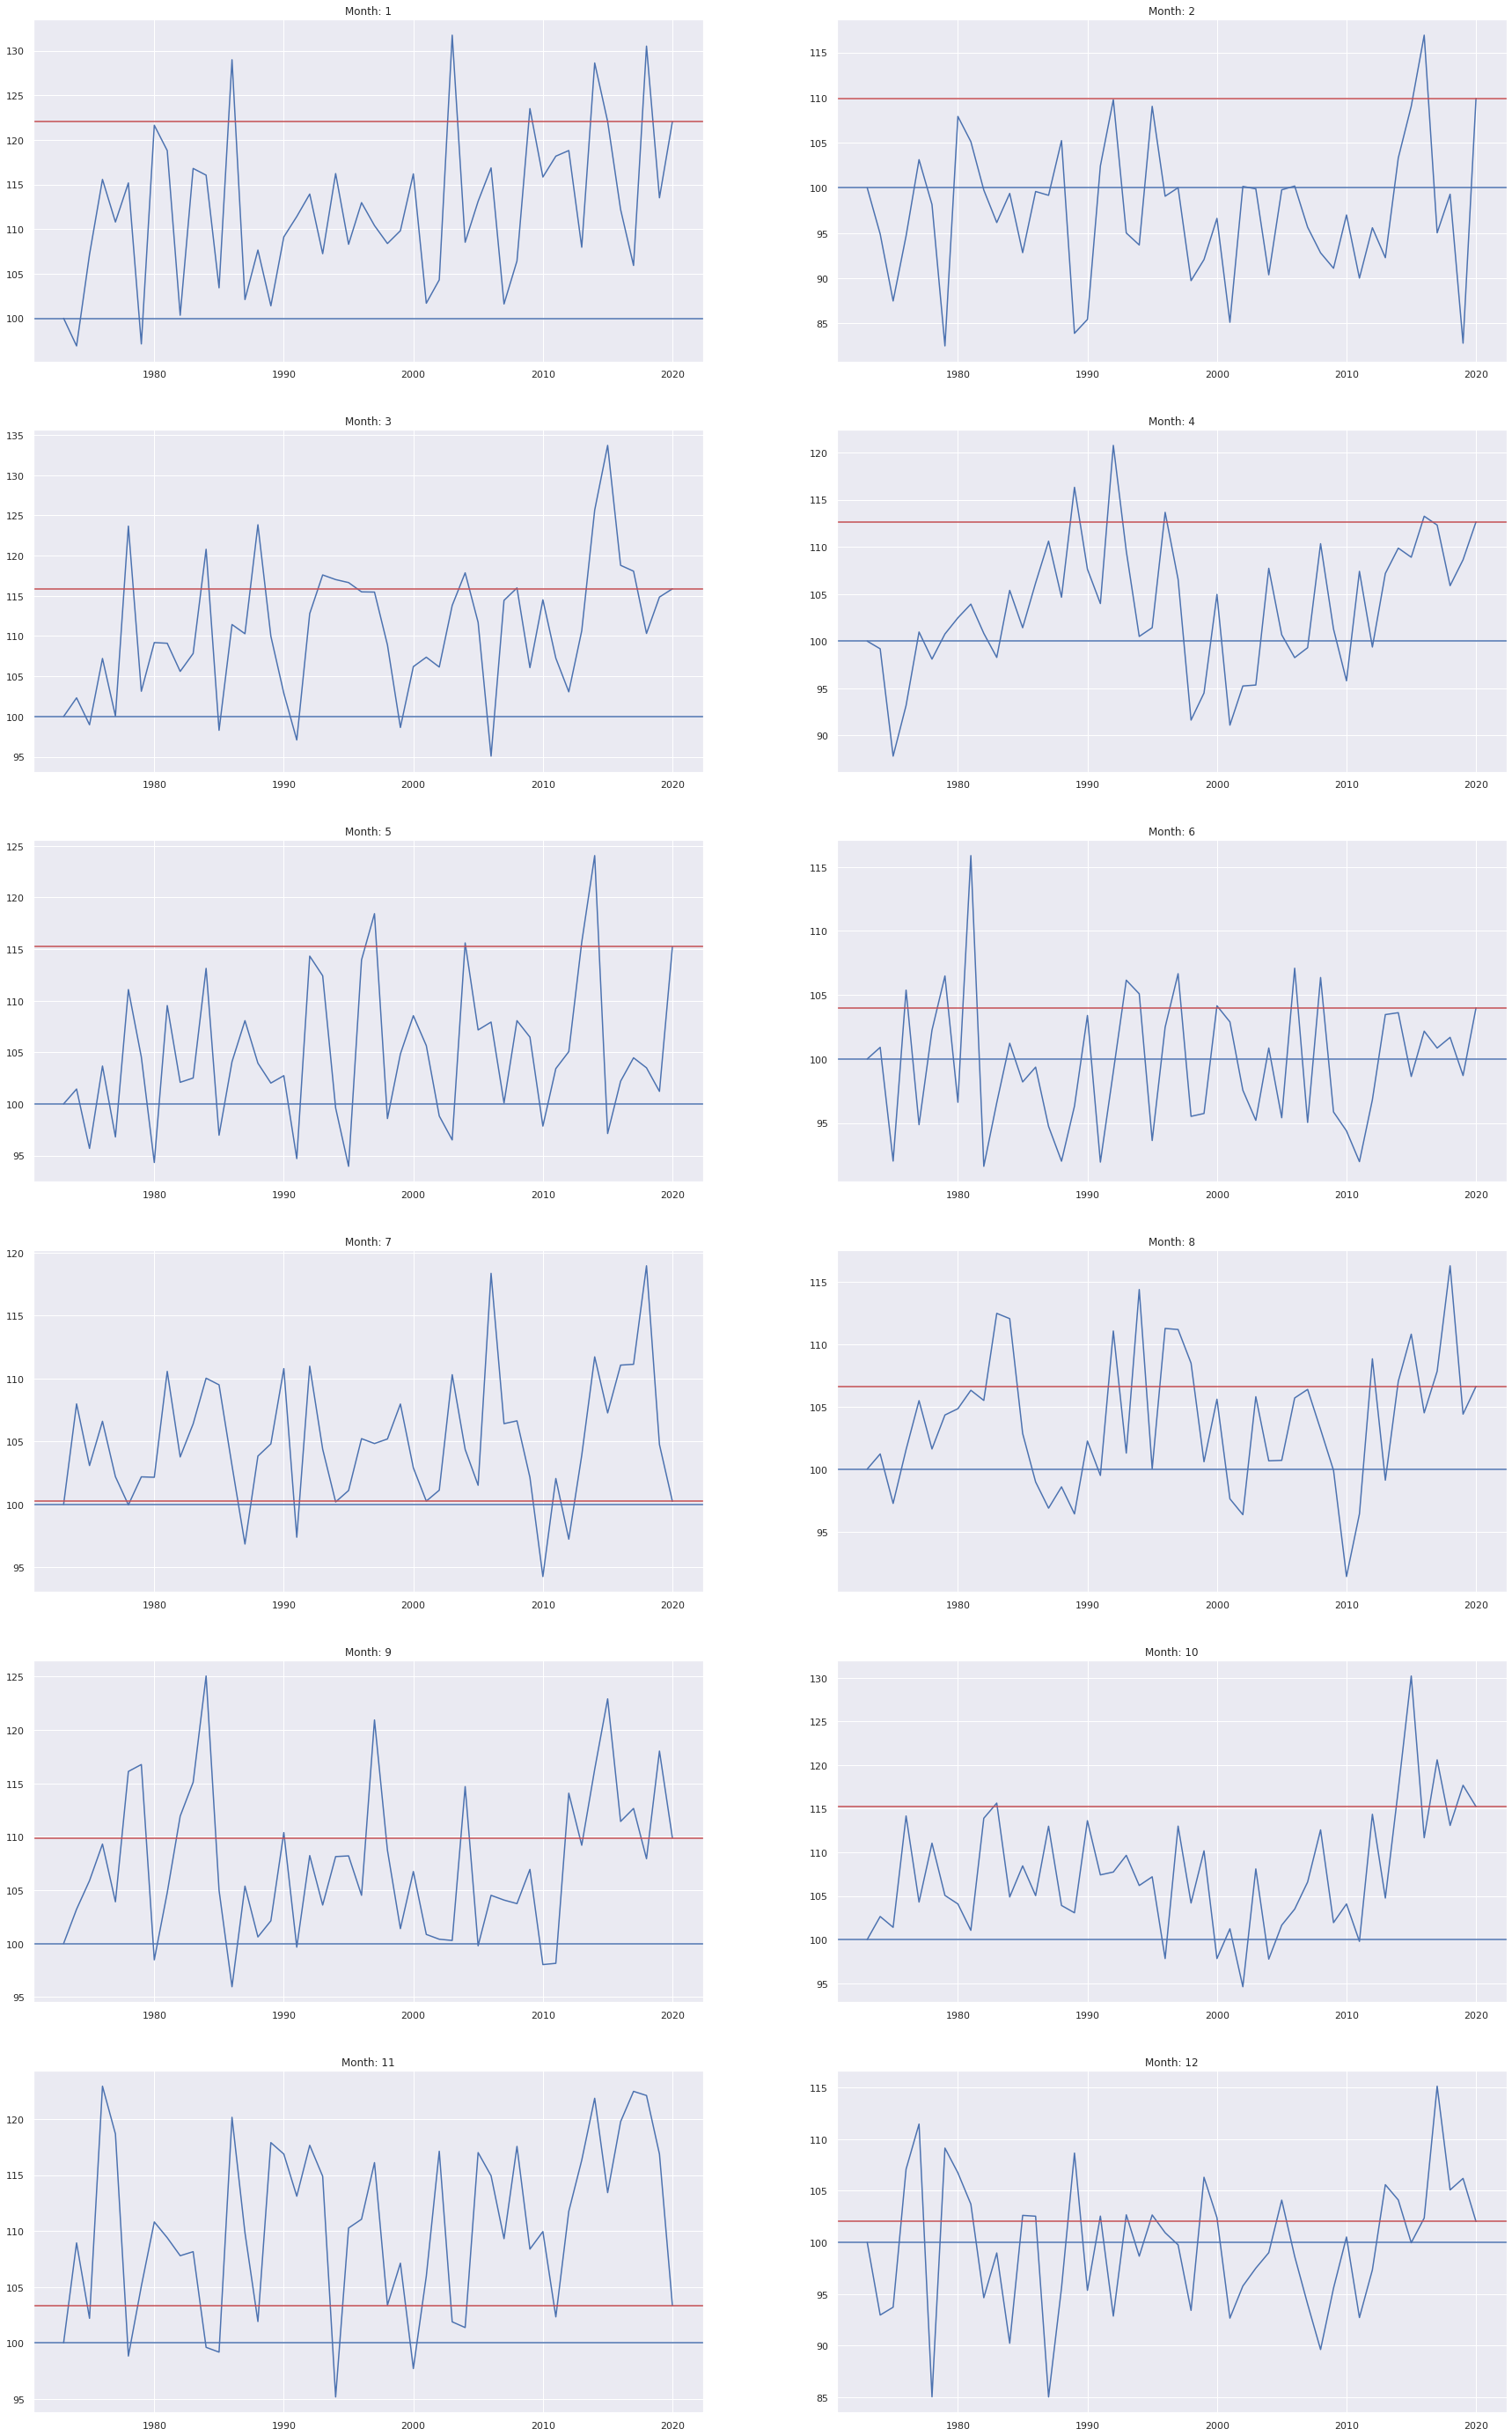

In [588]:
# Plotting normalized values
fig, axs = plt.subplots(6, 2, figsize=(30,50))
month = 1
for i in range(6):
    for j in range(2):
        axs[i, j].plot(monthly_mean_temp_pivot_normalized_df[month])
        axs[i, j].axhline(y=monthly_mean_temp_pivot_normalized_df[month].tail(1).values[0], color='r', linestyle='-')
        axs[i, j].axhline(y=100, color='b', linestyle='-')
        axs[i, j].set_title("Month: {}".format(month))
        month+=1

Quick observastions from the plot  
- There is a trend in the temperatures in January month from 1973 - 2020. The trend seems to be upward from the plot implying that Januray month has gotten hotter throuhghout these years
-  All the other months look pretty much stationary untill 2010 after which there is a sudden spike which also looks like a trend in some plots (4, 8, 9, 10, 11, 12)
- Overall the last decade for almost the months seems to be a little hotter than all ~40 years before. This is concerning as in just the last 10 years there is a visible shift in temperatures. Will the temperatures continue to rise over time? Or this is more of a cyclical process that would come down after some time? That's something that can be modelled, but at the same time there may be other factors too that may affect daily temperatures like cutting down forests, increase in air/land pollution, etc.

Let's see how the yearly mean temperatures have changed over these years

In [589]:
yearly_mean_temp_df = pd.DataFrame(air_temp_df.groupby(['year']).mean()['air_temp']).reset_index()
yearly_mean_temp_df.head()

,year,air_temp
0,1973,16.233858
1,1974,16.459874
2,1975,15.894669
3,1976,17.313707
4,1977,16.890765


In [590]:
yearly_mean_temp_df.tail(10)

,year,air_temp
38,2011,16.293538
39,2012,17.072086
40,2013,17.238303
41,2014,18.505104
42,2015,18.269974
43,2016,17.866348
44,2017,17.945708
45,2018,18.045644
46,2019,17.433916
47,2020,17.738643


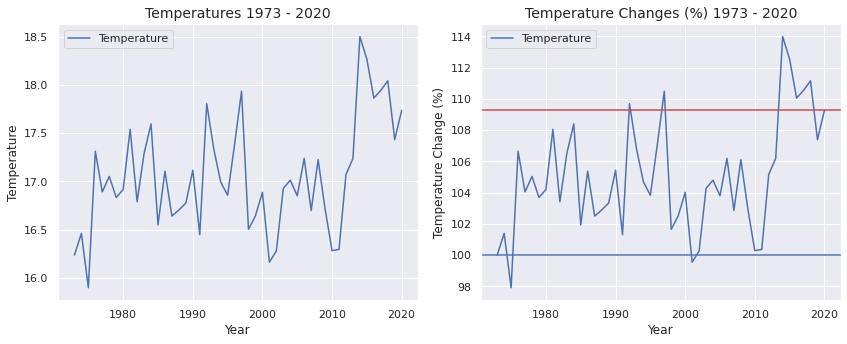

In [868]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(yearly_mean_temp_df['year'], yearly_mean_temp_df['air_temp'], label='Temperature')
ax1.set_title('Temperatures 1973 - 2020', fontsize=14)
ax1.set_ylabel('Temperature', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.legend()

# Normalizing for all years (and getting % changes)
yearly_mean_temp_df['normalized_air_temp'] = yearly_mean_temp_df['air_temp'].div(yearly_mean_temp_df['air_temp'].iloc[0]).mul(100)

ax2.plot(yearly_mean_temp_df['year'], yearly_mean_temp_df['normalized_air_temp'], label='Temperature')
ax2.axhline(y=100, color='b', linestyle='-')
ax2.axhline(y=yearly_mean_temp_df['normalized_air_temp'].tail(1).values[0] , color='r', linestyle='-')
ax2.set_title('Temperature Changes (%) 1973 - 2020', fontsize=14)
ax2.set_ylabel('Temperature Change (%)', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

The spike in the last decade for some months that we saw in the monthly plots seem to be evident in the yearly plot as well. As we can see there is a sudden spike in only the last decade. Of interest is the highest peak corresponding to  year 2014. That is a 14% jump compared to mean temperature of 1973! This was the hottest year in 134 years too! (https://earthobservatory.nasa.gov/images/85083/2014-was-the-warmest-year-in-the-modern-record).  
  
The yearly data in general looks stationary for the most part, again, except for the last decade where there seems to be as sudden spike. There seems a ~10% mean temperature increase  Can that be an indication of an upward trend? The last decade does look like trending upwards - doesn't it?

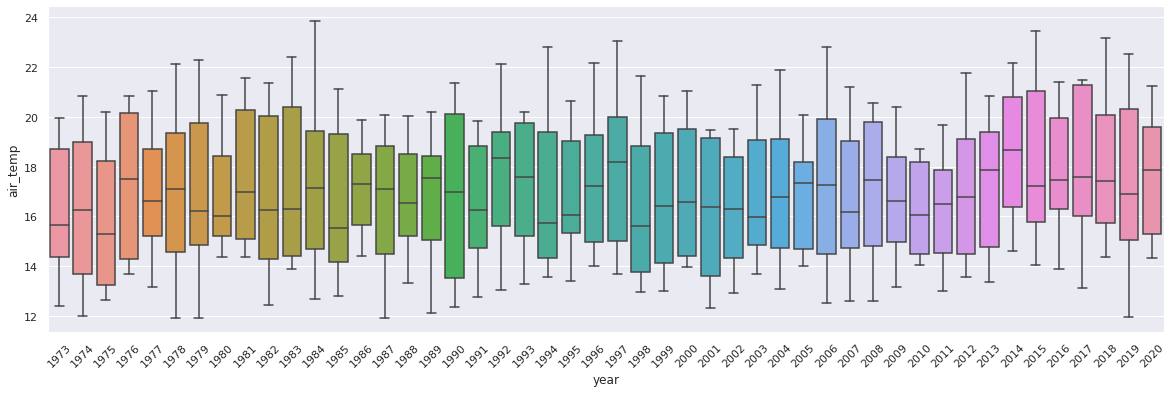

In [593]:
# Plotting box plot to see the spread if that has changed over years
figure(figsize=(20, 6))
sns.boxplot(x="year", y="air_temp", data=monthly_mean_temp_df)
plt.xticks(rotation=45)
plt.show()

Here I wanted to check if the monthly mean temperatures varied a lot for some years or whethere there was any trent in the variation. From the plot it looks like the variation has not changed much, but it does seem more for the last 6-7 years. Also, the entire distribition is shifted upwards a little for the last 7 years.

<AxesSubplot:xlabel='month', ylabel='air_temp'>

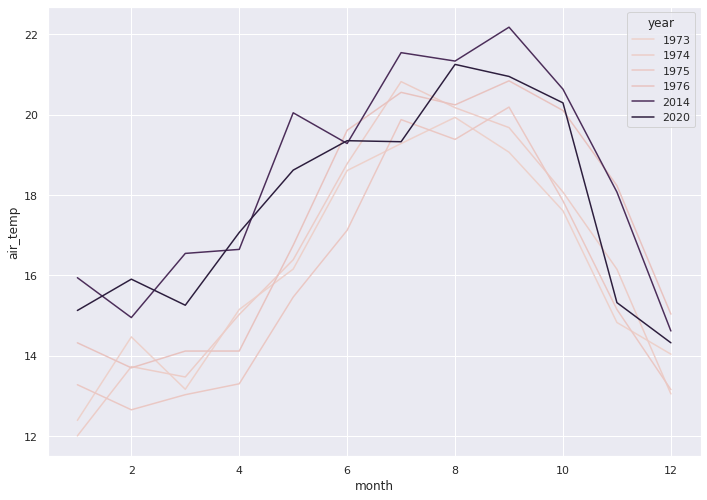

In [595]:
# Comparing monthly temperatures for the starting and ending years
sns.lineplot(data=monthly_mean_temp_df[(monthly_mean_temp_df['year'] == 1973) | 
                                       (monthly_mean_temp_df['year'] == 1974) | 
                                       (monthly_mean_temp_df['year'] == 1975) | 
                                       (monthly_mean_temp_df['year'] == 1976) |
                                       (monthly_mean_temp_df['year'] == 2014) |
                                       (monthly_mean_temp_df['year'] == 2020)], 
             x='month', 
             y='air_temp', 
             hue='year', 
             legend='full')

Here, I wanted to compare if recent years have become hotter overall compared to early years. It does look like the mean monthly temperatures for recent years are indeed more for almost all the months than for past years. Thus, the recent years have been hotter indeed than the past years in general.

<AxesSubplot:xlabel='month', ylabel='air_temp'>

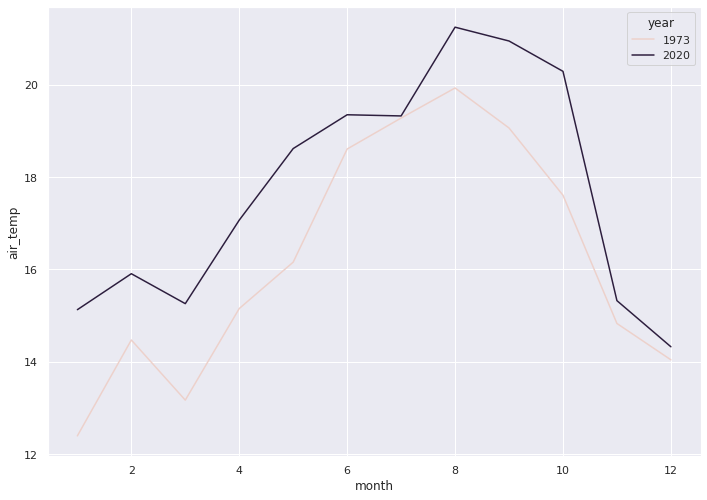

In [596]:
sns.lineplot(data=monthly_mean_temp_df[(monthly_mean_temp_df['year']==1973) | (monthly_mean_temp_df['year']==2020)], 
             x='month', 
             y='air_temp', 
             hue='year', 
             legend='full')

Decomposition

In [597]:
# Function to plot decomposition plots
def get_decomposition_plots(decomposed_ts):
    """Plots the decomposition plots"""
    fig, ax = plt.subplots(3,1, figsize=(15,8))
    decomposed_ts.trend.plot(ax=ax[0])
    ax[0].set_ylabel('Trend')
    decomposed_ts.resid.plot(ax=ax[1])
    ax[1].set_ylabel('Residual')
    decomposed_ts.seasonal.plot(ax=ax[2])
    ax[2].set_ylabel('Seasonality')
    plt.show()

Decomposing monthly means series

In [602]:
monthly_mean_temp_idx_df = monthly_mean_temp_df
monthly_mean_temp_idx_df['ts'] = monthly_mean_temp_idx_df.apply(lambda x: pd.Timestamp(x['year'], x['month'], 1, 0), axis=1)
monthly_mean_temp_idx_df = monthly_mean_temp_idx_df.set_index('ts')
monthly_mean_temp_idx_df = pd.DataFrame(monthly_mean_temp_idx_df['air_temp'])
monthly_mean_temp_idx_df.head()

,air_temp
ts,
1973-01-01,12.396505
1973-02-01,14.473363
1973-03-01,13.170699
1973-04-01,15.154167
1973-05-01,16.159274


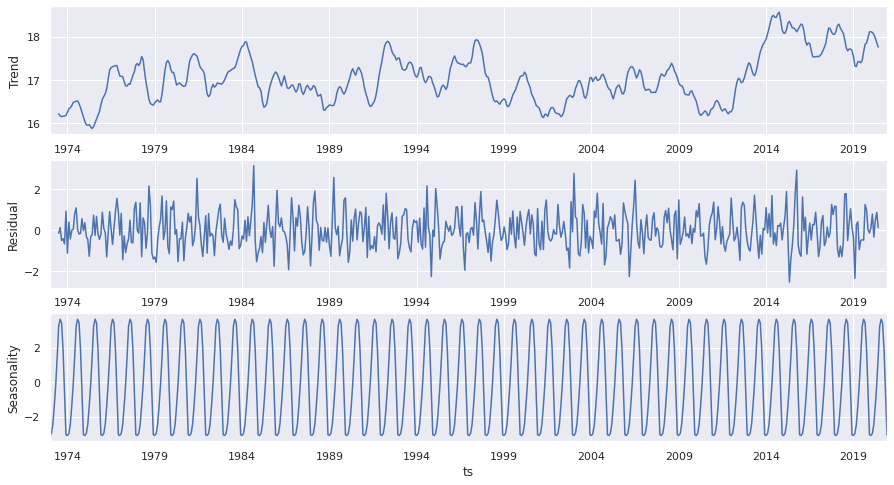

In [603]:
decomposition_month = sm.tsa.seasonal_decompose(monthly_mean_temp_idx_df['air_temp'])
get_decomposition_plots(decomposition_month)

The trend seems to be almost non existent except for the spike towards the end.  
The seasonality shows cycles implying the natural seasons that occur every year. The seasons repeat every year and that's what is evident from the plot too.  
The residuals seem to vary a little around a constant mean of 0.

Decomposing yearly means series

In [606]:
yearly_mean_temp_idx_df = yearly_mean_temp_df
yearly_mean_temp_idx_df['ts'] = yearly_mean_temp_idx_df.apply(lambda x: pd.Timestamp(x['year'], 12, 31, 0), axis=1)
yearly_mean_temp_idx_df = yearly_mean_temp_idx_df.set_index('ts')
yearly_mean_temp_idx_df = pd.DataFrame(yearly_mean_temp_idx_df['air_temp'])
yearly_mean_temp_idx_df.head()

,air_temp
ts,
1973-12-31,16.233858
1974-12-31,16.459874
1975-12-31,15.894669
1976-12-31,17.313707
1977-12-31,16.890765


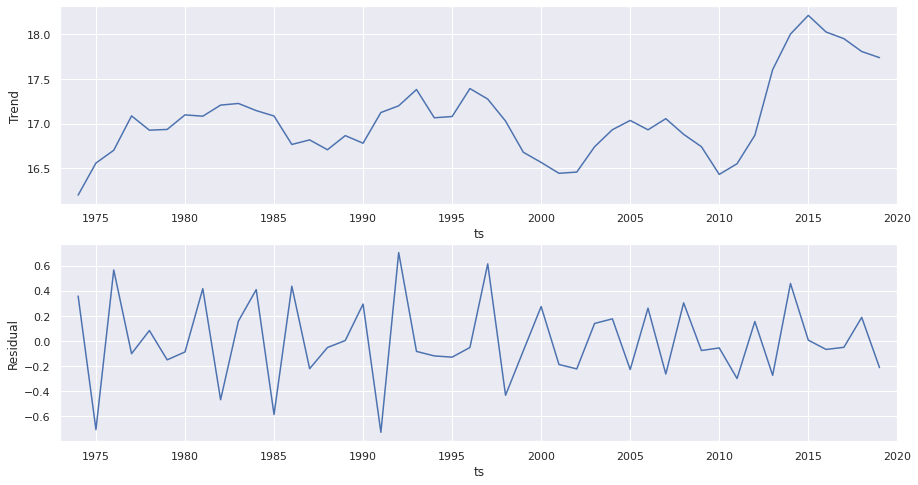

In [791]:
decomposition_year = sm.tsa.seasonal_decompose(yearly_mean_temp_idx_df['air_temp'], period=3)
fig, ax = plt.subplots(2,1, figsize=(15,8))
decomposition_year.trend.plot(ax=ax[0])
ax[0].set_ylabel('Trend')
decomposition_year.resid.plot(ax=ax[1])
ax[1].set_ylabel('Residual')
plt.show()

For the yearly means, the trend seems to be non existent except for the last 10 years where the trend is upwards.

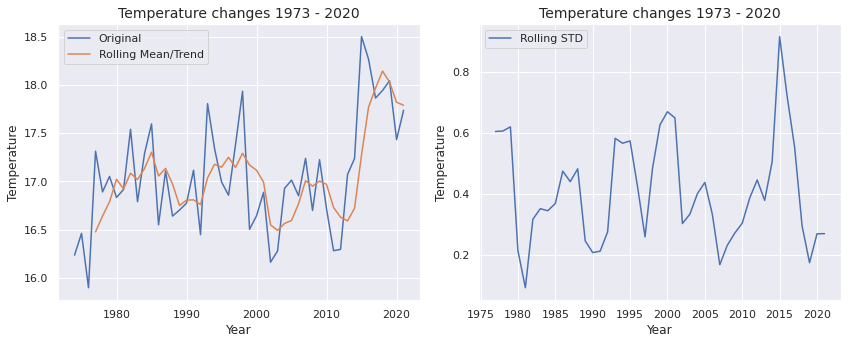

In [870]:
# Rolling mean and rolling std plots
rol_mean = yearly_mean_temp_idx_df.rolling(window=4).mean()
rol_std = yearly_mean_temp_idx_df.rolling(window=4).std()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(yearly_mean_temp_idx_df,label='Original')
ax1.plot(rol_mean,label='Rolling Mean/Trend')
ax1.set_title('Temperature changes 1973 - 2020',fontsize=14)
ax1.set_ylabel('Temperature',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

ax2.plot(rol_std,label='Rolling STD')
ax2.set_title('Temperature changes 1973 - 2020',fontsize=14)
ax2.set_ylabel('Temperature',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

Here a rolling mean was used to estimate the trend of the series and the observation is consistent with the previous one.  
The rolling standart deviation was almost stationary except for the last decade where there is a bump. This confirms a little suspiscion that was there seeing the box plot but it was not that clear from that that the variation in the last 7 years was that more as exhibitted by this plot.

## Modelling Time Series

In [609]:
monthly_mean_temp_idx_df.head()

,air_temp
ts,
1973-01-01,12.396505
1973-02-01,14.473363
1973-03-01,13.170699
1973-04-01,15.154167
1973-05-01,16.159274


Check for Stationarity and trend

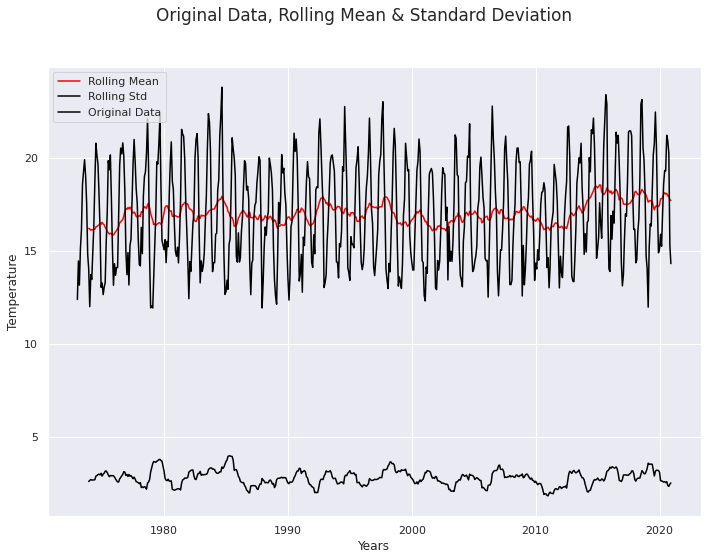

In [727]:
# Rolling mean and std 
rol_mean = monthly_mean_temp_idx_df.rolling(window=12).mean()
rol_std = monthly_mean_temp_idx_df.rolling(window=12).std()
plt.plot(rol_mean, color='red', label='Rolling Mean')
plt.plot(rol_std, color='black', label='Rolling Std')
plt.plot(monthly_mean_temp_idx_df, color='black', label='Original Data')

plt.legend(loc='best')
plt.suptitle('Original Data, Rolling Mean & Standard Deviation')
plt.xlabel('Years')
plt.ylabel('Temperature')
plt.show(block=False)

The series looks stationary for the most part and mean reverting. The standard deviation also doesn't look horribly bad. It looks more or less constant.

The ADF test tests for the following hypotheses:  
  
`H0: The series has a unit root` -- Not Stationary  
`H1: The series has no unit root` -- Stationary


In [794]:
# Augmented Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_result['Critical Value (%s)'%key] = value
    print (df_result)

#apply adf test on the series
adf_test(monthly_mean_temp_idx_df["air_temp"])

Results of Dickey-Fuller Test:
Test Statistic                  -3.609931
p-value                          0.005574
#Lags Used                      11.000000
Number of Observations Used    564.000000
Critical Value (1%)             -3.441998
Critical Value (5%)             -2.866678
Critical Value (10%)            -2.569506
dtype: float64


The p-value is less than 0.05 (significance level). Thus, we can reject the null hypothesis and say that the series is stationary. However, we should check for any trend as that's what our plots give a little hint of.

The KPSS test tests for the following hypotheses:  
  
`H0: The series is trend stationary` -- Stationary  
`H1: The series has a unit root ` -- Not Stationary


In [872]:
# KPSS test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpss_test = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpss_test[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(monthly_mean_temp_idx_df["air_temp"])

Results of KPSS Test:
Test Statistic            0.416723
p-value                   0.069947
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


The p-value is greater than the significance level (0.05). Thus, we fail to reject the null hypothis and conclude that the series is trend stationary. This supports the analysis so far. There indeed seemed to be a trend where temperatures tended to go up in the last decade or so. The line plots for both yearly and monthly analysis exhibited the same.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


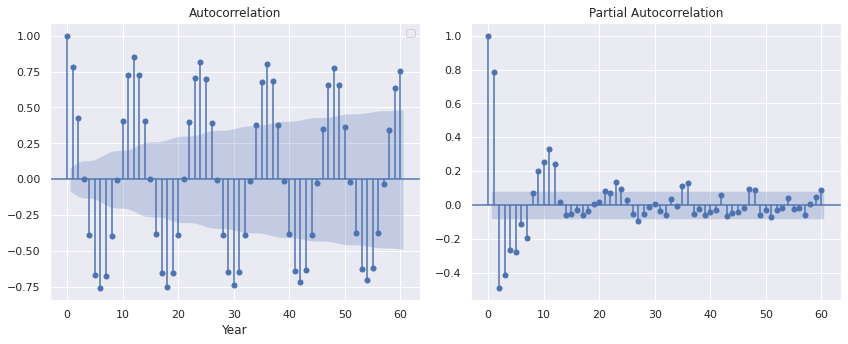

In [739]:
# Plot ACF and PACF 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
tsaplots.plot_acf(monthly_mean_temp_idx_df["air_temp"], lags=60, ax=ax1)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

tsaplots.plot_pacf(monthly_mean_temp_idx_df["air_temp"], lags=60, ax=ax2)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()
plt.tight_layout()
plt.show();

The ACF exhibits sesasonality - the autocorrelations cycle every 12 steps. That represens an year and the seasons in it that cycle naturally in time every year.  
We need to remove seasonality and plot these plots again.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


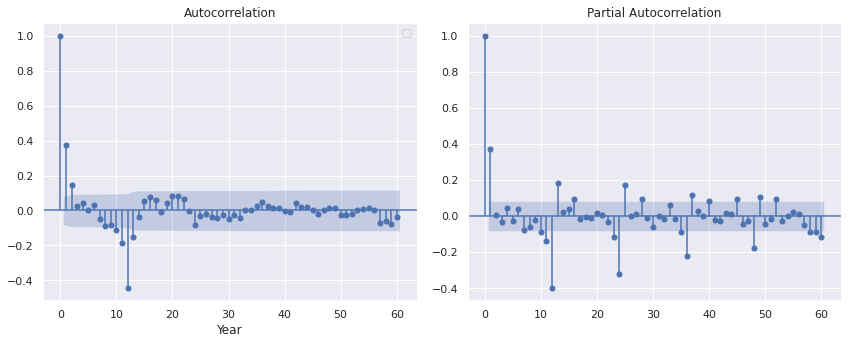

In [747]:
# Plot ACF and PACF  after de-seasonalizing
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
tsaplots.plot_acf(monthly_mean_temp_idx_df["air_temp"].diff(12).dropna(), lags=60, ax=ax1)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

tsaplots.plot_pacf(monthly_mean_temp_idx_df["air_temp"].diff(12).dropna(), lags=60, ax=ax2)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

plt.tight_layout()
plt.show();

There seems to be a positieve corelation with the 1st lag and this gradually dies out.  
There also seems to be a strong negative correlation at the 12th lag.

In [780]:
# Fitting SARIMA model
sarimax_mod = sm.tsa.statespace.SARIMAX(monthly_mean_temp_idx_df["air_temp"], trend='n', order=(3,0,2), seasonal_order=(1,0,1,12))
sarimax_mod_fit = sarimax_mod.fit()
sarimax_mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             air_temp   No. Observations:                  576
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -827.584
Date:                              Thu, 07 Oct 2021   AIC                           1671.168
Time:                                      09:44:20   BIC                           1706.017
Sample:                                  01-01-1973   HQIC                          1684.758
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6665      0.047     14.237      0.000       0.575       0.758
ar.L2          0.6526      0.020     31.913      0.000       0.613       0.693
ar.L3         -0.3201      0.035     -9.221      0.000      -0.388      -0.252
ma.L1         -0.2527      0.023    -10.996      0.000      -0.298      -0.208
ma.L2         -0.6946      0.022    -32.256      0.000      -0.737      -0.652
ar.S.L12       0.9996      0.001   1801.042      0.000       0.998       1.001
ma.S.L12      -0.9496      0.029    -32.754      0.000      -1.006      -0.893
sigma2         0.9512      0.061     15.472      0.000       0.831       1.072
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.47
Prob(Q):                              0.81   Prob(JB):                         0.48
Heteroskedasticity (H):               0.95   Skew:                             0.10
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I just wanted to fit the all the data to SARIMA model and looks like for the chosen values of lags and moving average, all the coefficients look statistically significant.

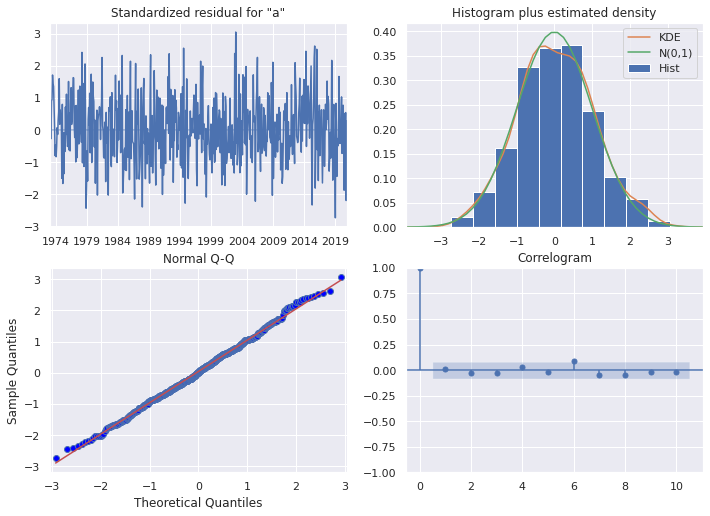

In [749]:
# Plotting SARIMA stats after fitting
sarimax_mod_fit.plot_diagnostics();

The residuals seem to have a uniform variance.  
The residuals look normally distributed around a mean of 0.  
The Q-Q plot shows that the residuaols are almost perfectly normally distributed.  
The residuals don't seem to have autocorrelation  

All things look good.


In [781]:
np.sqrt(mean_squared_error(sarimax_mod_fit.predict(), monthly_mean_temp_idx_df["air_temp"]))

1.1498730057872861

In [796]:
# Cross validation
tscv = TimeSeriesSplit(n_splits = 4)
rmse_train = []
rmse_valid = []
train_range = []
test_range = []
data_idx = monthly_mean_temp_idx_df.index

for train_index, test_index in tscv.split(monthly_mean_temp_idx_df.index):
    print("Train Range: {} - {}".format(data_idx[train_index[0]], data_idx[train_index[-1]]))
    print("Test Range: {} - {}".format(data_idx[test_index[0]], data_idx[test_index[-1]]))
    cv_train, cv_test = monthly_mean_temp_idx_df.iloc[train_index], monthly_mean_temp_idx_df.iloc[test_index]
    
    sarimax_mod = sm.tsa.statespace.SARIMAX(cv_train, trend='n', order=(3,0,2), seasonal_order=(1,0,1,12), initialization='approximate_diffuse')
    sarimax_mod_fit = sarimax_mod.fit()
    
    pred_train = sarimax_mod_fit.predict(cv_train.index.values[0], cv_train.index.values[-1])
    true_train = cv_train.values
    rmse_train.append(np.sqrt(mean_squared_error(true_train, pred_train)))
    
    pred_valid = sarimax_mod_fit.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_valid = cv_test.values
    rmse_valid.append(np.sqrt(mean_squared_error(true_valid, pred_valid)))
    
print("Train RMSE: {} - {}".format(np.mean(rmse_train), rmse_train))
print("Validation RMSE: {} - {}".format(np.mean(rmse_valid), rmse_valid))

Train Range: 1973-01-01 00:00:00 - 1982-08-01 00:00:00
Test Range: 1982-09-01 00:00:00 - 1992-03-01 00:00:00
Train Range: 1973-01-01 00:00:00 - 1992-03-01 00:00:00
Test Range: 1992-04-01 00:00:00 - 2001-10-01 00:00:00
Train Range: 1973-01-01 00:00:00 - 2001-10-01 00:00:00
Test Range: 2001-11-01 00:00:00 - 2011-05-01 00:00:00
Train Range: 1973-01-01 00:00:00 - 2011-05-01 00:00:00
Test Range: 2011-06-01 00:00:00 - 2020-12-01 00:00:00
Train RMSE: 1.7433697053956232 - [2.2602975996265795, 1.760769602416915, 1.5426749178391257, 1.4097367016998734]
Validation RMSE: 1.1737300206896197 - [1.1031943887032774, 1.0787264734997737, 0.9828409803230671, 1.530158240232361]


In [811]:
train = monthly_mean_temp_idx_df[: '2005-01-01']
test = monthly_mean_temp_idx_df['2005-01-01':]

sarimax_mod = sm.tsa.statespace.SARIMAX(train, trend='n', order=(3,0,2), seasonal_order=(1,0,1,12), initialization='approximate_diffuse')
sarimax_mod_fit = sarimax_mod.fit()

pred_train = sarimax_mod_fit.predict(train.index.values[0], train.index.values[-1])
true_train = train.values
print("RMSE - Train: {}".format(np.sqrt(mean_squared_error(true_train, pred_train))))

pred_test = sarimax_mod_fit.predict(test.index.values[0], test.index.values[-1])
true_test = test.values
print("RMSE - Train: {}".format(np.sqrt(mean_squared_error(true_test, pred_test))))


RMSE - Train: 1.4962763010507467
RMSE - Train: 1.316712753448809


In [879]:
pred.tail()

,predicted_mean
2026-09-01,19.850913
2026-10-01,18.179968
2026-11-01,15.707637
2026-12-01,13.593429
2027-01-01,13.411713


In [880]:
mean_temp_pred.tail()

,predicted_mean
2023,16.538323
2024,16.524292
2025,16.510283
2026,16.496295
2027,13.411713


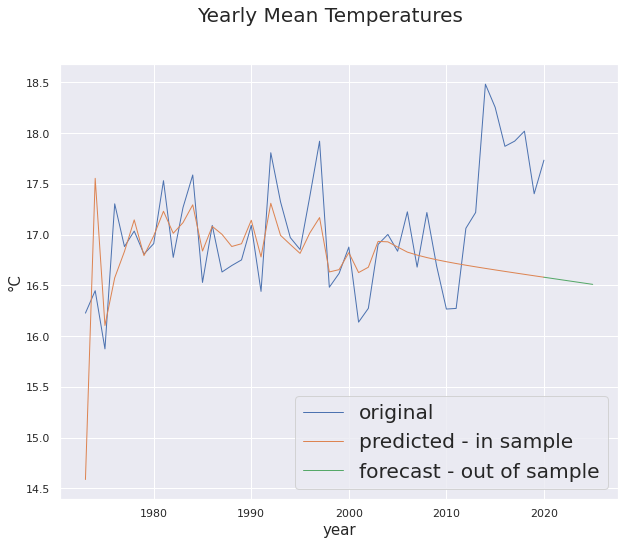

In [897]:
mean_temp_true = monthly_mean_temp_idx_df.groupby(monthly_mean_temp_idx_df.index.year).mean()
pred = pd.DataFrame(sarimax_mod_fit.predict('1973-1-01', '2020-12-01'))
mean_temp_pred = pred.groupby(pred.index.year).mean()
forecast = pd.DataFrame(sarimax_mod_fit.predict('2020-1-01', '2025-12-01'))
mean_forecast = forecast.groupby(forecast.index.year).mean()
fig, ax = plt.subplots(figsize=(10, 8))
mean_temp_true["air_temp"].plot(linewidth=1, label='original')
mean_temp_pred['predicted_mean'].plot(linewidth=1, label='predicted - in sample')
mean_forecast['predicted_mean'].plot(linewidth=1, label='forecast - out of sample')
plt.suptitle('Yearly Mean Temperatures', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize='x-large')
plt.grid(True)

The model performs okay and does need a substantial amount of tuning so that the error is really less and there is less bias and variance.  
  
Future steps would be to tune this model and see if the model is able to approximate the process. If that happens then one can make near to accurate forecasts and comment on whether the global warming will keep getting worse with time.  
  
Based on the analysis, we can say that the temperatures did increase over years in general and there's a hint of global warming and temperatures changing over time (climate change). One thing that should be noted is that we only worked on time-series data for one of the stations in the CA state. Of course, this is not representative of the overall planet but does give some insight into the trend for the selected location. This analysis could be worked on the aggregated data on a larger geography to make some generalizations.  
  
Also, there is also a lot of scope in learning characteristics of the cross-sectional aspect of the data.  